In [346]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import datetime
from datetime import timedelta
import math
import requests
import plotly as py
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt


import sklearn as sk
import sklearn.preprocessing
from sklearn import metrics
from matplotlib.pyplot import figure

from sklearn.preprocessing import  (StandardScaler, MinMaxScaler, LabelBinarizer)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LogisticRegression
import xgboost as xgb
from sklearn.metrics import *
# from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import tree
from sklearn import decomposition
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score


import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional

import plotly
import chart_studio
import plotly.express as px

# Creating DataFrame

In [347]:
#manipulatable variables
numDaysBack = str(365*5) #for daily you can go back multiple years worth, for daily you can only go back 90 days
myInterval = 'daily' # options are daily or hourly
theCoins = ['ethereum'] #can add more than one coin if you like
window_length = 14
mycom = 0.4
lower_macd_ema = 12
upper_macd_ema = 26
trigger_macd_ema = 9


def df_builder_clean(days, interval, coins):
    #manipulatable variables
    numDaysBack = days #for daily you can go back multiple years worth, for daily you can only go back 90 days
    myInterval = interval # options are daily or hourly
    theCoins = coins

    #builds initial dataframe with ethereum as first market but just to log the dates we are working with
    geckoReq = 'https://api.coingecko.com/api/v3/coins/ethereum/market_chart?vs_currency=usd&days='+numDaysBack+'&interval='+myInterval+''
    r = requests.get(geckoReq).json()
    ts = r['prices'][0][0]
    ts = ts/1000
    HistPricesList = []
    for i in range(len(r['prices'])):
        currentUnix = r['prices'][i][0] 
        price = r['prices'][i][1]
        currentUnix = currentUnix/1000
#         currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%d-%m-%Y %H:%M:%S") #adding dd-mm-yyyy hours minutes seconds
        currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%m-%d-%Y") #just the date mm-dd-yyyy
        HistPricesList.append([currentTS])
    global df
    df = pd.DataFrame(HistPricesList, columns = ['date'])

    
    #looping through each coin and adding in all data points and input variables
    for coin in theCoins:
        price_data(coin)
#         add_ewm(coin, mycom)
#         add_rsi(coin, window_length)
#         add_macd(coin, lower_macd_ema, upper_macd_ema, trigger_macd_ema)
        print('just added: ', coin)
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
#     print('r')
#     display(r)
    return df


def price_data(coin):
    global df
    # geckoReq = 'https://api.coingecko.com/api/v3/coins/ethereum/market_chart?vs_currency=usd&days=60&interval=daily'
    geckoReq = 'https://api.coingecko.com/api/v3/coins/'+coin+'/market_chart?vs_currency=usd&days='+numDaysBack+'&interval='+myInterval+''

    r = requests.get(geckoReq).json()
    ts = r['prices'][0][0]
    # print(ts)
    ts = ts/1000
    print(datetime.datetime.fromtimestamp(ts).strftime("%m-%d-%Y"))
    # print('prices length',len(r['prices']))
    HistPricesList = []
    for i in range(len(r['prices'])):
        currentUnix = r['prices'][i][0] 
        price = r['prices'][i][1]
        volume = r['total_volumes'][i][1]
        currentUnix = currentUnix/1000
        currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%m-%d-%Y")
    #     print('price: ', price, 'TS: ', currentTS)
        HistPricesList.append([currentTS, price, volume])
    #     currentUnix = currentTS
#         print(HistPricesList)
    dfCoin = pd.DataFrame(HistPricesList, columns = ['date', coin, coin+'_volume'])
#     print('dfCoin')
#     display(dfCoin)
    df = pd.merge(df, dfCoin[coin], left_on = df['date'], right_on=dfCoin['date']).drop(['key_0'], axis = 1)
    df = pd.merge(df, dfCoin[coin+'_volume'], left_on = df['date'], right_on=dfCoin['date']).drop(['key_0'], axis = 1)
    
def add_ewm(coin, mycom):
    df[coin+'_ewm'] = df[coin].ewm(com=mycom).mean()
    
def add_rsi(coin, window_length):
    global df
    df['diff'] = df[coin].diff(1)
    df['gain'] = df['diff'].clip(lower=0).round(2)
    df['loss'] = df['diff'].clip(upper=0).abs().round(2)
    
    # Get initial Averages
    df['avg_gain'] = df['gain'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]
    df['avg_loss'] = df['loss'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]

    # Get WMS averages
    # Average Gains
    for i, row in enumerate(df['avg_gain'].iloc[window_length+1:]):
        df['avg_gain'].iloc[i + window_length + 1] =\
            (df['avg_gain'].iloc[i + window_length] *
             (window_length - 1) +
             df['gain'].iloc[i + window_length + 1])\
            / window_length
    # Average Losses
    for i, row in enumerate(df['avg_loss'].iloc[window_length+1:]):
        df['avg_loss'].iloc[i + window_length + 1] =\
            (df['avg_loss'].iloc[i + window_length] *
             (window_length - 1) +
             df['loss'].iloc[i + window_length + 1])\
            / window_length
        
    df['rs'] = df['avg_gain'] / df['avg_loss']
    
    df['rsi'] = 100 - (100 / (1.0 + df['rs']))
    df = pd.DataFrame(df)
    df = df.drop(['gain', 'loss', 'avg_loss', 'avg_gain', 'rs'], axis = 1)
    
    #renaming diff and rsi columns
    dict = {'diff': coin+'_diff',
        'rsi': coin+'_rsi'}
    df.rename(columns=dict,
              inplace=True)

def add_macd(coin, lower_macd_ema, upper_macd_ema, trigger_macd_ema):
    global df
    #get ema for lower
    k = df[coin].ewm(span=lower_macd_ema, adjust = False, min_periods = lower_macd_ema).mean()

    #get ema for upper
    d = df[coin].ewm(span=upper_macd_ema, adjust=False, min_periods=upper_macd_ema).mean()

    macd = k-d
    
    # Get the 9-Day EMA of the MACD for the Trigger line
    macd_s = macd.ewm(span=trigger_macd_ema, adjust=False, min_periods=trigger_macd_ema).mean()
    # Calculate the difference between the MACD - Trigger for the Convergence/Divergence value
    macd_h = macd - macd_s
    # Add all of our new values for the MACD to the dataframe
    df['macd'] = df.index.map(macd)
    df['macd_h'] = df.index.map(macd_h)
    df['macd_s'] = df.index.map(macd_s)



mydf = pd.DataFrame(df_builder_clean(numDaysBack, myInterval, theCoins))
display(mydf)



08-18-2017
just added:  ethereum


,ethereum,ethereum_volume
date,,
2017-08-18,296.622090,5.537022e+08
2017-08-19,295.171577,3.428230e+08
2017-08-20,322.201220,1.743910e+09
2017-08-21,312.174471,8.983443e+08
2017-08-22,316.788920,4.664746e+08
...,...,...
2022-08-16,1896.031277,1.412055e+10
2022-08-16,1880.600101,1.424023e+10
2022-08-16,1880.600101,1.412055e+10


In [348]:
mydf.dropna(inplace=True)
# myCols = ['ethereum', 'ethereum_volume', 'ethereum_ewm', 'ethereum_rsi', 'macd', 'macd_h', 'macd_s', 'ethereum_diff']

In [349]:
my_data = mydf

###Need to add this att night when API adds same day values
display(my_data.tail(6))
my_data.drop(my_data.tail(6).index,
        inplace = True)


display(my_data)

,ethereum,ethereum_volume
date,,
2022-08-16,1896.031277,1.424023e+10
2022-08-16,1896.031277,1.412055e+10
2022-08-16,1880.600101,1.424023e+10
2022-08-16,1880.600101,1.412055e+10
2022-08-16,1896.031277,1.424023e+10
2022-08-16,1896.031277,1.412055e+10


,ethereum,ethereum_volume
date,,
2017-08-18,296.622090,5.537022e+08
2017-08-19,295.171577,3.428230e+08
2017-08-20,322.201220,1.743910e+09
2017-08-21,312.174471,8.983443e+08
2017-08-22,316.788920,4.664746e+08
...,...,...
2022-08-11,1881.427405,2.183707e+10
2022-08-12,1959.330925,1.584926e+10
2022-08-13,1982.411828,1.481675e+10


## LSTM Univariate Forecasting with Train-Val-Test Split and 3 day sliding window

In [350]:
#
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('2017-08-16')
datetime_object

datetime.datetime(2017, 8, 16, 0, 0)

In [351]:
my_data = df
#df.rename(columns={"date": "Date"})
df = df.rename(columns={"ethereum": "Close","date": "Date"})
#df = df.drop(columns = 'ethereum_volume')
df

,Close,ethereum_volume
date,,
2017-08-18,296.622090,5.537022e+08
2017-08-19,295.171577,3.428230e+08
2017-08-20,322.201220,1.743910e+09
2017-08-21,312.174471,8.983443e+08
2017-08-22,316.788920,4.664746e+08
...,...,...
2022-08-16,1896.031277,1.412055e+10
2022-08-16,1880.600101,1.424023e+10
2022-08-16,1880.600101,1.412055e+10


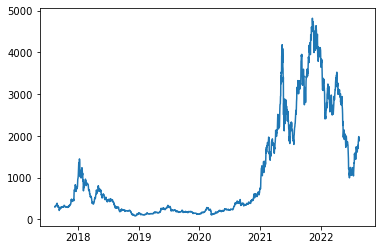

In [352]:
#Plotting the close price over specified time (5 years)
plt.plot(df.index, df['Close'])

plt.xlabel('Date')
plt.ylabel('ETH Price in $')

In [353]:
'''Function to create sliding window using 3 previous days as window length'''

def create_sliding_window(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
#creating target- i dates for 3 previous dates in our case  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
#Target is the oucome variable  
  ret_df['Target'] = Y

  return ret_df
# Start day first time around: '2017-08-19'
# Start day second time around: '2021-08-16'
sliding_window_df = create_sliding_window(df, 
                                '2017-08-22', 
                                '2022-08-15',
                                          n=3)
sliding_window_df




,Target Date,Target-3,Target-2,Target-1,Target
0,2017-08-22,295.171577,322.201220,312.174471,316.788920
1,2017-08-23,322.201220,312.174471,316.788920,321.785298
2,2017-08-24,312.174471,316.788920,321.785298,329.025281
3,2017-08-25,316.788920,321.785298,329.025281,329.865783
4,2017-08-26,321.785298,329.025281,329.865783,343.341337
...,...,...,...,...,...
1815,2022-08-11,1775.701356,1698.966129,1852.878555,1881.427405
1816,2022-08-12,1698.966129,1852.878555,1881.427405,1959.330925
1817,2022-08-13,1852.878555,1881.427405,1959.330925,1982.411828
1818,2022-08-14,1881.427405,1959.330925,1982.411828,1936.701164


In [354]:
'''this function takes sliding window df, output is date, 3d matrix X of 3 day windowed dates, and the target close price Y
Used to convert df into np array to feed into the lstm model'''
def sliding_window_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()
#take in first column as dates
  dates = df_as_np[:, 0]
#takes middle 3 cols as middle 3d matrix
  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))
# y is target column
  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = sliding_window_df_to_date_X_y(sliding_window_df)

dates.shape, X.shape, y.shape

((1820,), (1820, 3, 1), (1820,))

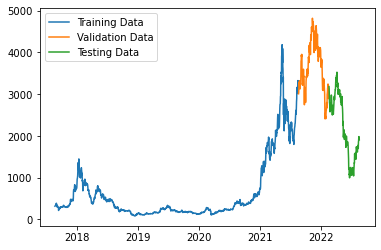

In [355]:
#split data into train-test validation 80-10-10%
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

#training = first  80% of data
dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
#validation to get data between 80-90%
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
#test data is 90-100%
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)
plt.xlabel('Date')
plt.ylabel('ETH Price in $')
plt.legend(['Training Data', 'Validation Data', 'Testing Data'])

In [356]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
#best model is full 5 year with LSTM 200 , dense layers 80, learning rate .001

#rectified linear activation function or ReLU for short is a piecewise linear function that will output the input directly
#if it is positive, otherwise, it will output zero. It has become the default activation function for many types of neural networks
#because a model that uses it is easier to train and often achieves better performance.
model = Sequential([layers.Input((3, 1)),                       #3 for 3 days in past and 1 for target
                    layers.LSTM(200),
                    layers.Dense(80, activation='relu'),
                    layers.Dense(80, activation='relu'),
                    layers.Dense(1)])
#default linear output, ideal for univariate outcomes
model.summary()
######Dannys Model implementation 

# model = keras.Sequential()
# model.add(keras.layers.LSTM(100, return_sequences=True, input_shape=(3, 1)))
# model.add(keras.layers.LSTM(100, return_sequences=False))
# model.add(keras.layers.Dense(25))
# model.add(keras.layers.Dense(1))
# model.summary()


######

model.compile(loss='mse',                                     #we are looking to minimize MSE
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])              #tells us the average of how much we are off by in our prediction, compared to the mean square value. value is not differentiable


model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=13)

#best performence 81 for 5 year dataset 

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 200)               161600    
                                                                 
 dense_36 (Dense)            (None, 80)                16080     
                                                                 
 dense_37 (Dense)            (None, 80)                6480      
                                                                 
 dense_38 (Dense)            (None, 1)                 81        
                                                                 
Total params: 184,241
Trainable params: 184,241
Non-trainable params: 0
_________________________________________________________________
Epoch 1/13
46/46 [==============================] - 2s 14ms/step - loss: 907510.1250 - mean_absolute_error: 596.9955 - val_loss: 13142629.0000 - val_mean_absolute_error: 3575.3301

46/46 [==============================] - 0s 2ms/step


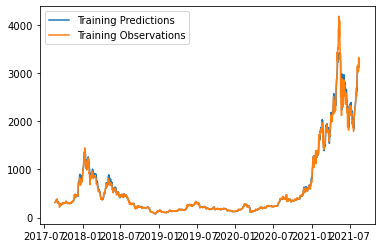

In [357]:
#Prediction on the training set 
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.xlabel('Date')
plt.ylabel('ETH Price in $')
plt.legend(['Training Predictions', 'Training Observations'])

In [358]:
#plotly graph of train set 

fig = px.line(x=dates_train, y=[y_train, train_predictions],labels={'wide_variable_0':'Train Predictions', 'wide_variable_1':'Train Observations'})

fig.update_layout(
    title="Training Set Predictions (Red) vs Actual (Blue)",
    xaxis_title="Date",
    yaxis_title="Price ($)",
    font=dict(
        family="Arial, monospace",
        size=18,
        color="Black"
    )
)

fig.update_layout(legend_title_text = "Plots")
fig.update_traces(showlegend=False)
fig.show()

6/6 [==============================] - 0s 7ms/step


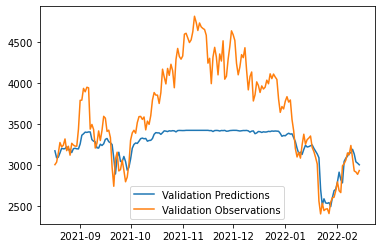

In [359]:
#prediction on the validation set
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.xlabel('Date')
plt.ylabel('ETH Price in $')
plt.legend(['Validation Predictions', 'Validation Observations'])

In [360]:
#plotly graph of val set 


fig = px.line(x=dates_val, y=[y_val, val_predictions],labels={'wide_variable_0':'Validation Predictions', 'wide_variable_1':'Validation Observations'})

fig.update_layout(
    title="Validation Set Predictions (Red) vs Actual (Blue)",
    xaxis_title="Date",
    yaxis_title="Price ($)",
    font=dict(
        family="Arial, monospace",
        size=18,
        color="Black"
    )
)

fig.update_layout(legend_title_text = "Plots")
fig.update_traces(showlegend=False)
fig.show()

6/6 [==============================] - 0s 3ms/step


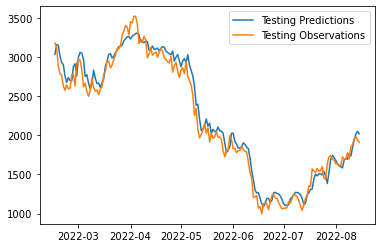

In [361]:
#Prediction on testing set 
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.xlabel('Date')
plt.ylabel('ETH Price in $')
plt.legend(['Testing Predictions', 'Testing Observations'])

#seems to predict downfalls better than upticks 

In [362]:
#plotly graph of test set 


fig = px.line(x=dates_test, y=[y_test, test_predictions],labels={'wide_variable_0':'Test Predictions', 'wide_variable_1':'Test Observations'})

fig.update_layout(
    title="Test Set Predictions (Red) vs Actual (Blue)",
    xaxis_title="Date",
    yaxis_title="Price ($)",
    font=dict(
        family="Arial, monospace",
        size=18,
        color="Black"
    )
)

fig.update_layout(legend_title_text = "Plots")
fig.update_traces(showlegend=False)
fig.show()

In [363]:
from sklearn.metrics import r2_score

print('R2_score for Training Set: ', r2_score(y_train, train_predictions))
print('R2_score for Validation Set: ', r2_score(y_val, val_predictions))
print('R2_score for Test Set: ', r2_score(y_test, test_predictions))

R2_score for Training Set:  0.9896533080152631
R2_score for Validation Set:  0.07083109590160397
R2_score for Test Set:  0.9698724359608772


In [364]:
rmse_train = np.sqrt(np.mean(train_predictions - y_train)**2)
rmse_val = np.sqrt(np.mean(val_predictions - y_val)**2)
rmse_test = np.sqrt(np.mean(test_predictions - y_test)**2)
print('RMSE for Training Set: ',rmse_train)
print('RMSE for Validation Set: ',rmse_val)
print('RMSE for Testing Set: ',rmse_test)

RMSE for Training Set:  7.104269504547119
RMSE for Validation Set:  383.6580810546875
RMSE for Testing Set:  52.23227310180664


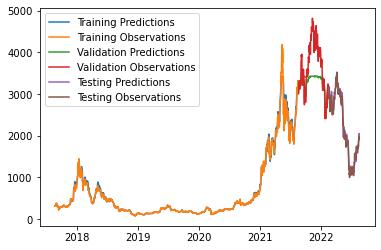

In [365]:
#combined prediction on train/val/testing
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

Perhaps LSTM models are not great for extrapolation of data. It does not deal with data outside of its range well. The information from the training data does not help predict the latter values with a volatile increases accuratley. 

In [366]:
#making future predictions 
from copy import deepcopy

# recursive_predictions = []
# #predictions for last 20% of data using training Data
# recursive_dates = np.concatenate([dates_val, dates_test])


# #loop through recursive dates and make predictions 

# for target_date in recursive_dates:
#   last_window = deepcopy(X_train[-1])
#   next_prediction = model.predict(np.array([last_window])).flatten()
#   recursive_predictions.append(next_prediction) #add predictions to list
#   last_window[-1] = next_prediction   


#3 day window
recursive_predictions = []
recursive_dates = dates_test[-7:]
last_window  = X_test[-7]

for target_date in recursive_dates:
    print(last_window)
    next_prediction = model.predict(np.array([last_window])).flatten()
    recursive_predictions.append(next_prediction)
    new_window = list(last_window[1:])
    new_window.append(next_prediction)
    new_window = np.array(new_window)
    last_window = new_window

[[1693.2966]
 [1699.0065]
 [1775.7014]]
1/1 [==============================] - 0s 14ms/step
[[1699.0065]
 [1775.7014]
 [1769.9469]]
1/1 [==============================] - 0s 18ms/step
[[1775.7014]
 [1769.9469]
 [1802.3805]]
1/1 [==============================] - 0s 15ms/step
[[1769.9469]
 [1802.3805]
 [1831.1313]]
1/1 [==============================] - 0s 18ms/step
[[1802.3805]
 [1831.1313]
 [1874.2806]]
1/1 [==============================] - 0s 15ms/step
[[1831.1313]
 [1874.2806]
 [1926.7195]]
1/1 [==============================] - 0s 16ms/step
[[1874.2806]
 [1926.7195]
 [1987.3724]]
1/1 [==============================] - 0s 16ms/step


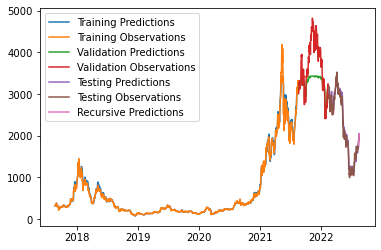

In [367]:
mpl_fig = plt.figure()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])

In [368]:
recursive_predictions[0:]

[array([1769.9469], dtype=float32),
 array([1802.3805], dtype=float32),
 array([1831.1313], dtype=float32),
 array([1874.2806], dtype=float32),
 array([1926.7195], dtype=float32),
 array([1987.3724], dtype=float32),
 array([2049.384], dtype=float32)]

In [369]:
#actual values of last 7 day price 
y_test.tolist
print(y_test[-7:])

[1698.9662 1852.8785 1881.4274 1959.3309 1982.4119 1936.7012 1908.2776]


In [374]:
##recursively predicted values of last 7 day price 
# myl = [1769.9469,1802.3805,1831.1313,1874.2806,1926.7195,1987.3724,2049.384]
# myl

[1769.9469, 1802.3805, 1831.1313, 1874.2806, 1926.7195, 1987.3724, 2049.384]

In [370]:
# pd.DataFrame(y_test)
data = mydf.filter(['ethereum'])
data = data.tail(len(y_test))
data['Predictions'] = test_predictions
display(data)
validation = data

,ethereum,Predictions
date,,
2022-02-15,3179.300207,3033.818115
2022-02-16,3128.640781,3158.602783
2022-02-17,2881.613122,3152.917480
2022-02-18,2792.303848,3012.685303
2022-02-19,2768.971652,2930.754639
...,...,...
2022-08-11,1881.427405,1846.740601
2022-08-12,1959.330925,1940.652954
2022-08-13,1982.411828,2016.360474


In [371]:
moneyStart = 1000
money = moneyStart
eth = money/validation['ethereum'].iloc[1]
validation['buy'] = np.where(validation['ethereum'] > validation['Predictions'], 1, 0)
# validation['sell'] = np.where(validation['ethereum'] < validation['Predictions'], 1, 0)
validation['signal'] = validation['buy'].diff()
validation['money'] = moneyStart
validation = validation.iloc[1:, :]
validation['eth'] = moneyStart/eth
display(validation.head(5))
for index, row in validation.iterrows():
    if row['signal'] == 1:
#         print('buy')
#         print('money: ',  money, 'price: ', row['ethereum'])
        eth = money/row['ethereum']
        validation.loc[index, 'eth'] = eth
        validation.loc[index, 'money'] = money
        row['eth'] = eth
    elif row['signal'] == -1:
#         print('sell')
        money = eth*row['ethereum']
        validation.loc[index, 'eth'] = eth
        validation.loc[index, 'money'] = money
    else:
        validation.loc[index, 'eth'] = eth
        validation.loc[index, 'money'] = money
display(validation)
#     print(moneyStart/row['Close'])

<ipython-input-371-719820f1c52c>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,ethereum,Predictions,buy,signal,money,eth
date,,,,,,
2022-02-16,3128.640781,3158.602783,0,-1.0,1000,3128.640781
2022-02-17,2881.613122,3152.917480,0,0.0,1000,3128.640781
2022-02-18,2792.303848,3012.685303,0,0.0,1000,3128.640781
2022-02-19,2768.971652,2930.754639,0,0.0,1000,3128.640781
2022-02-20,2632.491399,2902.815674,0,0.0,1000,3128.640781


C:\Users\YM\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,ethereum,Predictions,buy,signal,money,eth
date,,,,,,
2022-02-16,3128.640781,3158.602783,0,-1.0,1000.000000,0.319628
2022-02-17,2881.613122,3152.917480,0,0.0,1000.000000,0.319628
2022-02-18,2792.303848,3012.685303,0,0.0,1000.000000,0.319628
2022-02-19,2768.971652,2930.754639,0,0.0,1000.000000,0.319628
2022-02-20,2632.491399,2902.815674,0,0.0,1000.000000,0.319628
...,...,...,...,...,...,...
2022-08-11,1881.427405,1846.740601,1,0.0,972.491444,0.524854
2022-08-12,1959.330925,1940.652954,1,0.0,972.491444,0.524854
2022-08-13,1982.411828,2016.360474,0,-1.0,1040.477551,0.524854


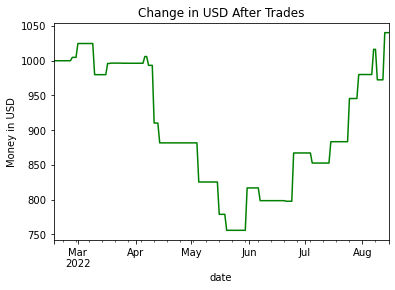

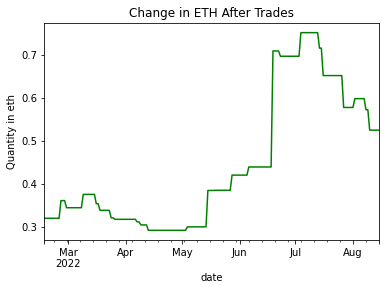

In [372]:
plt.xlabel('Date')
plt.ylabel('Money in USD')
plt.title('Change in USD After Trades')
validation['money'].plot(color='g', label = 'money')
plt.show()
plt.xlabel('Date')
plt.ylabel('Quantity in eth')
plt.title('Change in ETH After Trades')
validation['eth'].plot(color='g', label = 'eth')
plt.show()

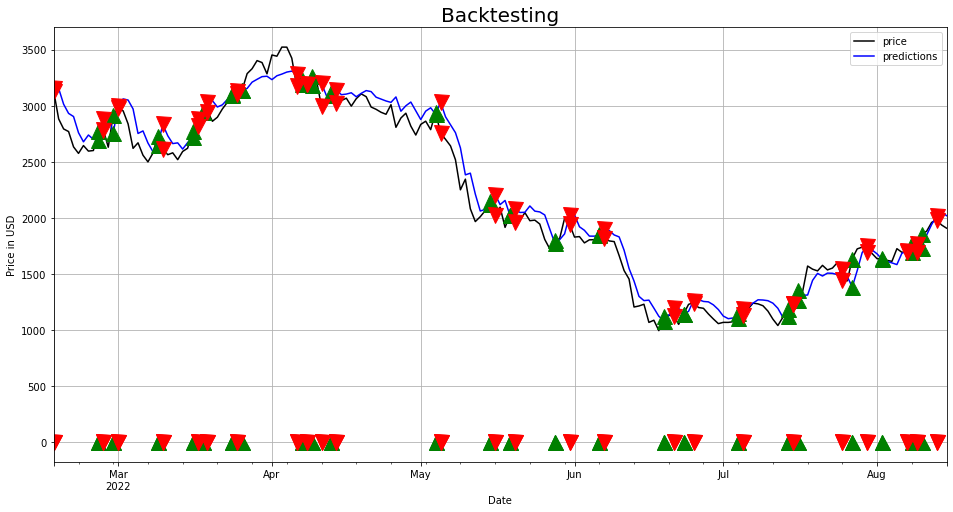

In [373]:
validation = validation.drop(columns = ['eth','money'])

plt.figure(figsize = (16, 8))
validation['ethereum'].plot(color='k', label = 'price')
validation['Predictions'].plot(color='b', label='predictions')
plt.plot(validation[validation['signal']==1].index, validation[validation['signal']==1],'^', markersize = 15, color='g')
plt.plot(validation[validation['signal']==-1].index, validation[validation['signal']==-1],'v', markersize = 15, color='r')
plt.ylabel('Price in USD')
plt.xlabel('Date')
plt.title('Backtesting', fontsize = 20)
plt.legend()
plt.grid()
plt.show()